### Roadmap:
To compare the pick rates and win rates of Overwatch heroes in high ranked competitive ladder play versus the ban statistics of the Overwatch Championship Series (OWCS). Additionally, I will do some analysis of just the ban data in OWCS, such as which teams ban which heroes more frequently.

End goal will have two data frames, one of OW heroes, pick rates, and win rates, sourced from Blizzard's official website. The other data frame will have OW heroes and how many times they were banned in OWCS matches.

In [2]:
# install and import packages
%pip install pandas
%pip install matplotlib
%pip install sqlalchemy

import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import sqlite3
import json

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### OWCS Format
In OWCS, professional matches consist of five standard games of Overwatch, one of each map type (Control, Escort, Hybrid, Push, and Flashpoint) in a first to 3 (best-of 5) format. From now on, I'll be referring to the standard games as "maps" and full best-of 5s as "matches". In each map, both teams ban one hero and they must be from separate roles (two Damage heroes cannot be banned in the same map) and a hero cannot be banned in the match by the same team twice. For example, if Geekay Esports bans Juno in their first map, they cannot ban her again for the entirety of the match, but their opponent can. 

Inspecting the CSV, there is extensive data that I won't be using in this project. Per map, there are 5 elements for hero bans, suggesting that there is a lot of duplicate data. This is partly true, it shows a ban for each player of the team even though each team can only ban 1 hero. I've chosen to build a primary key based on the match, map, and hero ban as that's what I'll be focusing on. 

The following code imports the match history of OWCS in North America, Europe, Africa, and the Middle East. It also cleans up the data by resolving typos and making sure there is only one instance of each map. 

In [ ]:

# Load the OWCS dataset
file_path = 'final_project_data_sources/faceit_all_matches_emea_na_all_stages.csv'
owcs_df = pd.read_csv(file_path)

# Create the primary key by concatenating the specified columns
owcs_df['primary_key'] = (
    owcs_df['match_id'].astype(str) + '-' +
    owcs_df['match_date'].astype(str) + '-' +
    owcs_df['round_num'].astype(str) + '-' +
    owcs_df['map_type'].astype(str) + '-' +
    owcs_df['map_name'].astype(str) + '-' +
    owcs_df['hero_bans'].astype(str) + '-' +
    owcs_df['team'].astype(str)
)

# Keep only the primary key column and remove duplicates
owcs_df = owcs_df[['primary_key', 'match_id', 'match_date', 'round_num', 'map_type', 'map_name', 'hero_bans', 'team']].drop_duplicates().reset_index(drop=True)

# Remove typos
owcs_df['hero_bans'] = owcs_df['hero_bans'].replace({
    'Lucio': 'Lúcio',
    'Zenyetta': 'Zenyatta',
    'Torbjorn': 'Torbjörn',
    'Junkerqueen': 'Junker Queen',
    'Dva': 'D.Va',
})


# Display the first few rows of the dataframe
print('First 5 rows of the OWCS dataset:')
print(owcs_df.head())

# Display dataframe info to understand columns and data types
print('\nOWCS DataFrame Info:')
owcs_df.info()

First 5 rows of the OWCS dataset:
                                         primary_key             match_id  \
0  EMEA_S1_RR_W4_D2_M1-2025-02-22T18:51:05-1-Cont...  EMEA_S1_RR_W4_D2_M1   
1  EMEA_S1_RR_W4_D2_M1-2025-02-22T18:51:05-1-Cont...  EMEA_S1_RR_W4_D2_M1   
2  EMEA_S1_RR_W4_D2_M1-2025-02-22T18:51:05-2-Push...  EMEA_S1_RR_W4_D2_M1   
3  EMEA_S1_RR_W4_D2_M1-2025-02-22T18:51:05-2-Push...  EMEA_S1_RR_W4_D2_M1   
4  EMEA_S1_RR_W4_D2_M1-2025-02-22T18:51:05-3-Flas...  EMEA_S1_RR_W4_D2_M1   

            match_date  round_num map_type   map_name     hero_bans       team  
0  2025-02-22T18:51:05          1  Control      Samoa          Juno  Team Peps  
1  2025-02-22T18:51:05          1  Control      Samoa      Torbjörn     Sakura  
2  2025-02-22T18:51:05          2     Push  Esperanca        Pharah  Team Peps  
3  2025-02-22T18:51:05          2     Push  Esperanca  Junker Queen     Sakura  
4  2025-02-22T18:51:05          3    Flash   Suravasa        Tracer  Team Peps  

OWCS DataFrame I

### Blizzard Official Win and Pick Rates Data
This code imports the Blizzard official data from their website which I downloaded as a plain text html to preserve as a "snapshot in time". When Overwatch has an update, all of this data changes and it could skew results. Particularly, if the site is scraped directly following an update, numbers are much more likely to be outliers such as 70%+ win rates simply due to the limited sample size. 

The data is made up of hero names, win rates, and pick rates. Specifically, win rate is determined by how many games are won when the character is played and is not mirrored (only one team plays the hero). Note that in mirrored matches, hero win rates will always be 50%. Pick rate is determined by how often the hero is played. 

Due to some strangeness from their website set-up, I had to do two separate scrapes which added in some duplicate data and text which I needed to clean up. 


In [ ]:
snapshot_file_path = 'final_project_data_sources/Overwatch 2 - Hero Statistics.html'
hero_stats = []

with open(snapshot_file_path, 'r') as f:
    content = f.read()

# extract only the win and pick rate data from the HTML content
start_marker = """Pick Rate


Win Rate"""
end_marker = '\nFrequently Asked Questions'

elements = content.split(end_marker)
data = []
for el in elements:
    if start_marker in el:
        for sub_el in el.split(start_marker):
            data.append(sub_el)

# ignore the data we dont care about
win_and_pick_data = str(data[1] + data[3])

# remove white space
win_and_pick_data = win_and_pick_data.strip()

# in the raw html there are duplicate lines like 'Ana\nAna' which we need to remove
lines = win_and_pick_data.split('\n')
result = [lines[0]]

for line in lines[1:]:
    if line != result[-1] and line.strip() != '':
        result.append(line)

for i in range(0, len(result), 3):
    if i + 2 < len(result):
        hero_name = result[i].strip()
        pick_rate_str = result[i+1].strip()
        win_rate_str = result[i+2].strip()
        
        # Clean and convert to float
        pick_rate = float(pick_rate_str.replace('%', ''))
        win_rate = float(win_rate_str.replace('%', ''))
        
        hero_stats.append({
            'Hero': hero_name,
            'Pick Rate (%)': pick_rate,
            'Win Rate (%)': win_rate
        })

# remove duplicate entries
hero_stats = list({json.dumps(d, sort_keys=True): d for d in hero_stats}.values())

ow_ranked_df = pd.DataFrame(hero_stats)

print('First 5 rows of the Overwatch Ranked Stats dataset:')
print(ow_ranked_df.head())

print('\nOverwatch Ranked Stats DataFrame Info:')
ow_ranked_df.info()



First 5 rows of the Overwatch Ranked Stats dataset:
       Hero  Pick Rate (%)  Win Rate (%)
0       Ana           40.2          48.0
1      Ashe           19.6          53.7
2  Baptiste           12.5          48.6
3   Bastion            5.5          48.8
4  Brigitte            9.6          50.1

Overwatch Ranked Stats DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Hero           44 non-null     object 
 1   Pick Rate (%)  44 non-null     float64
 2   Win Rate (%)   44 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.2+ KB


### Hero and Role CSV
Just for my own purposes, I wanted to be able to categorize all of this data by each hero's role (Tank, Damage, or Support). Given this dataset was very small (44 rows), I just made it myself. 

In [ ]:
# Import the heroes CSV
heroes_df = pd.read_csv('final_project_data_sources/ow_heroes.csv')

# sort heroes by role then by name
role_order = {'Tank': 0, 'Damage': 1, 'Support': 2}
heroes_df['role_priority'] = heroes_df['role'].map(role_order)
heroes_df = heroes_df.sort_values(by=['role_priority', 'hero_name']).reset_index(drop=True)
heroes_df = heroes_df.drop(columns=['role_priority'])

print(heroes_df)

        hero_name     role
0            D.Va     Tank
1        Doomfist     Tank
2          Hazard     Tank
3    Junker Queen     Tank
4           Mauga     Tank
5           Orisa     Tank
6        Ramattra     Tank
7       Reinhardt     Tank
8         Roadhog     Tank
9           Sigma     Tank
10        Winston     Tank
11  Wrecking Ball     Tank
12          Zarya     Tank
13           Ashe   Damage
14        Bastion   Damage
15        Cassidy   Damage
16           Echo   Damage
17          Freja   Damage
18          Genji   Damage
19          Hanzo   Damage
20        Junkrat   Damage
21            Mei   Damage
22         Pharah   Damage
23         Reaper   Damage
24        Sojourn   Damage
25    Soldier: 76   Damage
26         Sombra   Damage
27       Symmetra   Damage
28       Torbjörn   Damage
29         Tracer   Damage
30        Venture   Damage
31     Widowmaker   Damage
32            Ana  Support
33       Baptiste  Support
34       Brigitte  Support
35         Illari  Support
3

### Data Transformation
Finally, I transform the data from OWCS into how many times each hero was banned. Then I merge it into the OW ranked pick and win rates to try and find a correlation on a scatter plot for both bans vs win rate and pick rate vs win rate. 

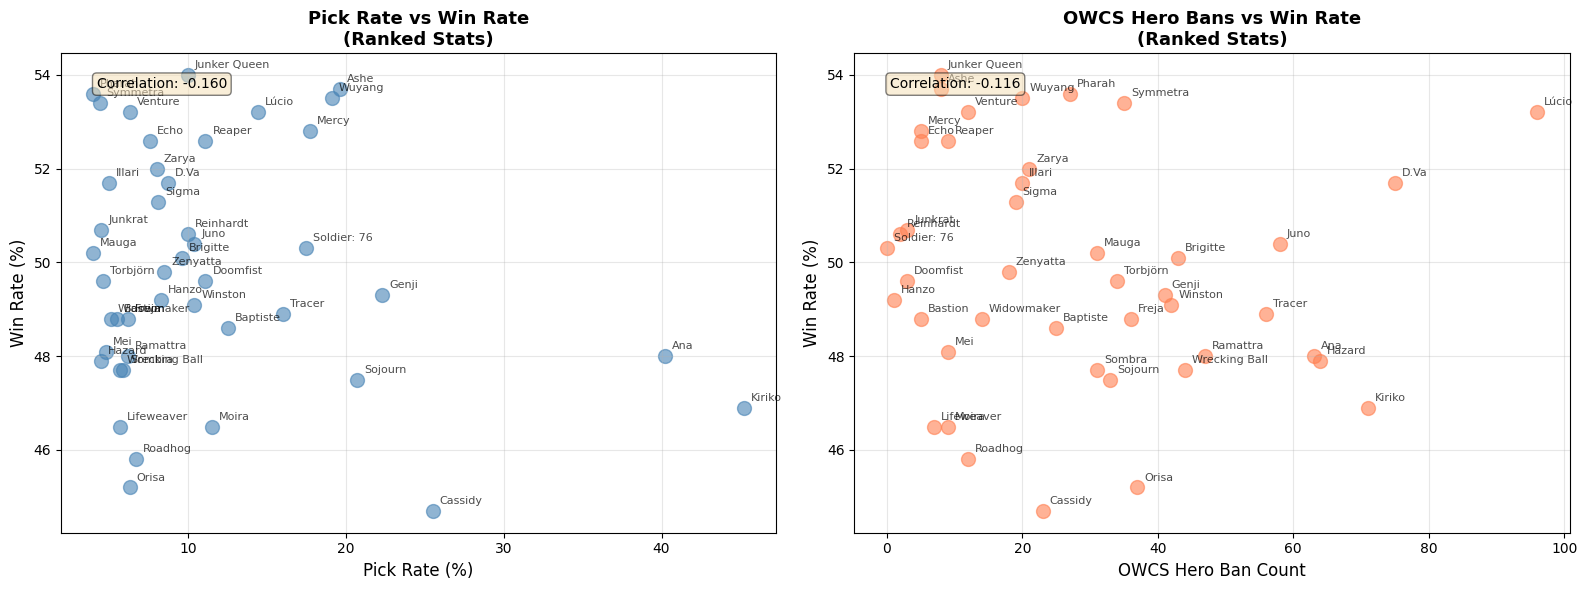

Pick Rate vs Win Rate Correlation: -0.16008706724374647
OWCS Hero Bans vs Win Rate Correlation: -0.11638407797311064

Top 10 Most Banned Heroes in OWCS:
            Hero  ban_count
0          Lúcio         96
1           D.Va         75
2         Kiriko         71
3         Hazard         64
4            Ana         63
5           Juno         58
6         Tracer         56
7       Ramattra         47
8  Wrecking Ball         44
9       Brigitte         43


In [8]:
# Count hero ban frequency in OWCS data
ban_counts = owcs_df['hero_bans'].value_counts().reset_index()
ban_counts.columns = ['Hero', 'ban_count']

# Merge ban counts with ranked stats
ranked_stats_with_bans = ow_ranked_df.merge(
    ban_counts,
    left_on='Hero',
    right_on='Hero',
    how='left'
)

# Fill NaN ban counts with 0 (heroes not banned in OWCS)
ranked_stats_with_bans['ban_count'] = ranked_stats_with_bans['ban_count'].fillna(0)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Pick Rate vs Win Rate (original data)
axes[0].scatter(
    ow_ranked_df['Pick Rate (%)'],
    ow_ranked_df['Win Rate (%)'],
    alpha=0.6,
    s=100,
    color='steelblue'
)

# Add hero names to plot 1
for idx, row in ow_ranked_df.iterrows():
    axes[0].annotate(
        row['Hero'],
        (row['Pick Rate (%)'], row['Win Rate (%)']),
        fontsize=8,
        alpha=0.7,
        xytext=(5, 5),
        textcoords='offset points'
    )

axes[0].set_xlabel('Pick Rate (%)', fontsize=12)
axes[0].set_ylabel('Win Rate (%)', fontsize=12)
axes[0].set_title('Pick Rate vs Win Rate\n(Ranked Stats)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add correlation coefficient
corr_pick_win = ow_ranked_df['Pick Rate (%)'].corr(ow_ranked_df['Win Rate (%)'])
axes[0].text(0.05, 0.95, f'Correlation: {corr_pick_win:.3f}', 
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: OWCS Hero Bans vs Win Rate
axes[1].scatter(
    ranked_stats_with_bans['ban_count'],
    ranked_stats_with_bans['Win Rate (%)'],
    alpha=0.6,
    s=100,
    color='coral'
)

# Add hero names to plot 2
for idx, row in ranked_stats_with_bans.iterrows():
    axes[1].annotate(
        row['Hero'],
        (row['ban_count'], row['Win Rate (%)']),
        fontsize=8,
        alpha=0.7,
        xytext=(5, 5),
        textcoords='offset points'
    )

axes[1].set_xlabel('OWCS Hero Ban Count', fontsize=12)
axes[1].set_ylabel('Win Rate (%)', fontsize=12)
axes[1].set_title('OWCS Hero Bans vs Win Rate\n(Ranked Stats)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add correlation coefficient
corr_ban_win = ranked_stats_with_bans['ban_count'].corr(ranked_stats_with_bans['Win Rate (%)'])
axes[1].text(0.05, 0.95, f'Correlation: {corr_ban_win:.3f}', 
             transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print("Pick Rate vs Win Rate Correlation:", corr_pick_win)
print("OWCS Hero Bans vs Win Rate Correlation:", corr_ban_win)
print("\nTop 10 Most Banned Heroes in OWCS:")
print(ban_counts.nlargest(10, 'ban_count'))


In [ ]:
engine = create_engine('sqlite:///overwatch.db')

# Prepare the data for SQL
# 1. Heroes table
heroes_table = ow_ranked_df[['Hero']].drop_duplicates().reset_index(drop=True)
heroes_table['hero_id'] = range(1, len(heroes_table) + 1)
heroes_table = heroes_table[['hero_id', 'Hero']]

# 2. Ranked Stats table (with hero_id foreign key)
ranked_stats_sql = ow_ranked_df.merge(
    heroes_table,
    left_on='Hero',
    right_on='Hero',
    how='left'
)
ranked_stats_sql = ranked_stats_sql[['hero_id', 'Hero', 'Pick Rate (%)', 'Win Rate (%)']]

# 3. OWCS Bans table (with hero_id foreign key)
ban_counts = owcs_df['hero_bans'].value_counts().reset_index()
ban_counts.columns = ['Hero', 'ban_count']
owcs_bans_sql = ban_counts.merge(
    heroes_table,
    left_on='Hero',
    right_on='Hero',
    how='left'
)
owcs_bans_sql = owcs_bans_sql[['hero_id', 'Hero', 'ban_count']]

# Load tables into SQL database
heroes_table.to_sql('heroes', con=engine, if_exists='replace', index=False)
ranked_stats_sql.to_sql('ranked_stats', con=engine, if_exists='replace', index=False)
owcs_bans_sql.to_sql('owcs_bans', con=engine, if_exists='replace', index=False)

print("✓ Tables created successfully!\n")

# Now run example queries

conn = sqlite3.connect('overwatch.db')
cursor = conn.cursor()

# Query 1: Top 10 heroes by win rate
print("=" * 60)
print("QUERY 1: Top 10 Heroes by Win Rate")
print("=" * 60)
query1 = """
SELECT 
    h.Hero,
    rs.'Win Rate (%)' as win_rate,
    rs.'Pick Rate (%)' as pick_rate
FROM heroes h
JOIN ranked_stats rs ON h.hero_id = rs.hero_id
ORDER BY rs.'Win Rate (%)' DESC
LIMIT 10;
"""
result1 = pd.read_sql_query(query1, conn)
print(result1)
print()

# Query 2: Top 10 most banned heroes in OWCS
print("=" * 60)
print("QUERY 2: Top 10 Most Banned Heroes in OWCS")
print("=" * 60)
query2 = """
SELECT 
    h.Hero,
    ob.ban_count,
    rs.'Win Rate (%)' as win_rate
FROM heroes h
JOIN owcs_bans ob ON h.hero_id = ob.hero_id
JOIN ranked_stats rs ON h.hero_id = rs.hero_id
ORDER BY ob.ban_count DESC
LIMIT 10;
"""
result2 = pd.read_sql_query(query2, conn)
print(result2)
print()

# Query 3: Heroes with inversely correlated ban count and win rate
print("=" * 60)
print("QUERY 3: Inverse Correlation Score")
print("=" * 60)
query3 = """
WITH stats AS (
    SELECT
        h.Hero,
        ob.ban_count,
        rs."Win Rate (%)" AS win_rate,
        rs."Pick Rate (%)" AS pick_rate,
        AVG(rs."Win Rate (%)") OVER () AS avg_win,
        AVG(ob.ban_count) OVER () AS avg_ban
    FROM heroes h
    JOIN owcs_bans ob ON h.hero_id = ob.hero_id
    JOIN ranked_stats rs ON h.hero_id = rs.hero_id
)
SELECT
    Hero,
    ban_count,
    win_rate,
    pick_rate,
    ROUND(
        (win_rate - avg_win) * (avg_ban - ban_count),
        2
    ) AS inverse_correlation_score
FROM stats
ORDER BY inverse_correlation_score DESC;

"""
result3 = pd.read_sql_query(query3, conn)
print(result3)
print()

# Query 4: Average win rate of banned vs non-banned heroes
print("=" * 60)
print("QUERY 4: Average Win Rate - Banned vs Non-Banned Heroes")
print("=" * 60)
query4 = """
SELECT 
    CASE 
        WHEN ob.ban_count IS NULL THEN 'Never Banned'
        WHEN ob.ban_count = 0 THEN 'Never Banned'
        ELSE 'Banned in OWCS'
    END as ban_status,
    COUNT(h.hero_id) as hero_count,
    ROUND(AVG(rs.'Win Rate (%)'), 2) as avg_win_rate,
    ROUND(AVG(rs.'Pick Rate (%)'), 2) as avg_pick_rate
FROM heroes h
JOIN ranked_stats rs ON h.hero_id = rs.hero_id
LEFT JOIN owcs_bans ob ON h.hero_id = ob.hero_id
GROUP BY ban_status;
"""
result4 = pd.read_sql_query(query4, conn)
print(result4)
print()

# Query 5: Correlation between ban count and win rate
print("=" * 60)
print("QUERY 5: Heroes Ranked by Ban Count with Win Rate")
print("=" * 60)
query5 = """
SELECT 
    h.Hero,
    COALESCE(ob.ban_count, 0) as ban_count,
    rs.'Win Rate (%)' as win_rate,
    rs.'Pick Rate (%)' as pick_rate
FROM heroes h
JOIN ranked_stats rs ON h.hero_id = rs.hero_id
LEFT JOIN owcs_bans ob ON h.hero_id = ob.hero_id
ORDER BY COALESCE(ob.ban_count, 0) DESC;
"""
result5 = pd.read_sql_query(query5, conn)
print(result5)
print()

conn.close()


✓ Tables created successfully!

QUERY 1: Top 10 Heroes by Win Rate
           Hero  win_rate  pick_rate
0  Junker Queen      54.0       10.0
1          Ashe      53.7       19.6
2        Pharah      53.6        4.0
3        Wuyang      53.5       19.1
4      Symmetra      53.4        4.4
5         Lúcio      53.2       14.4
6       Venture      53.2        6.3
7         Mercy      52.8       17.7
8          Echo      52.6        7.6
9        Reaper      52.6       11.1

QUERY 2: Top 10 Most Banned Heroes in OWCS
            Hero  ban_count  win_rate
0          Lúcio         96      53.2
1           D.Va         75      51.7
2         Kiriko         71      46.9
3         Hazard         64      47.9
4            Ana         63      48.0
5           Juno         58      50.4
6         Tracer         56      48.9
7       Ramattra         47      48.0
8  Wrecking Ball         44      47.7
9       Brigitte         43      50.1

QUERY 3: Inverse Correlation Score
             Hero  ban_count

### OWCS Ban Concentration Data 

Finally, I was curious to see ban data dependent on each team, like do certain teams ban one hero much more than others, and what was each team's favorite ban?

I also imported my hero and role csv into a SQL table to see what percentage of bans were of each role, and what the most frequently banned character of each role was.

In [27]:
# Create a connection to SQLite database
engine = create_engine('sqlite:///overwatch.db')

# Prepare team bans data from OWCS
team_bans = owcs_df[['team', 'hero_bans']].copy()
team_bans.columns = ['team', 'Hero']

# Merge with heroes table to get hero_id
team_bans = team_bans.merge(
    heroes_table,
    left_on='Hero',
    right_on='Hero',
    how='left'
)

# Count bans by team and hero
team_bans_counts = team_bans.groupby(['team', 'Hero', 'hero_id']).size().reset_index(name='ban_count')

# Load into SQL
team_bans_counts.to_sql('team_bans', con=engine, if_exists='replace', index=False)

print("✓ Team Bans table created successfully!\n")

# Now run queries
import sqlite3

conn = sqlite3.connect('overwatch.db')
cursor = conn.cursor()

# Query 1: Ban diversity by team (using Shannon Entropy)
print("=" * 80)
print("QUERY 1: Team Ban Diversity (Most to Least Diverse)")
print("=" * 80)
query_diversity = """
SELECT 
    team,
    COUNT(DISTINCT Hero) as unique_heroes_banned,
    SUM(ban_count) as total_bans,
    ROUND(COUNT(DISTINCT Hero) * 1.0 / SUM(ban_count), 3) as diversity_ratio
FROM team_bans
GROUP BY team
ORDER BY diversity_ratio DESC;
"""
result_diversity = pd.read_sql_query(query_diversity, conn)
print(result_diversity)
print()

# Query 2: Heroes with skewed ban distribution (one team bans them way more)
print("=" * 80)
print("QUERY 2: Heroes with Skewed Ban Distribution (One Team Primarily Bans Them)")
print("=" * 80)
query_skewed = """
SELECT 
    h.Hero,
    SUM(tb.ban_count) as total_bans,
    COUNT(DISTINCT tb.team) as teams_that_banned,
    MAX(tb.ban_count) as max_team_bans,
    (SELECT team FROM team_bans WHERE Hero = h.Hero ORDER BY ban_count DESC LIMIT 1) as top_banning_team,
    ROUND(MAX(tb.ban_count) * 1.0 / SUM(tb.ban_count), 3) as concentration_ratio
FROM heroes h
JOIN team_bans tb ON h.hero_id = tb.hero_id
GROUP BY h.Hero
HAVING concentration_ratio > 0.4
ORDER BY concentration_ratio DESC;
"""
result_skewed = pd.read_sql_query(query_skewed, conn)
print(result_skewed)
print()

# Query 3: Detailed breakdown - which team bans which hero most
print("=" * 80)
print("QUERY 3: Top 5 Hero Bans by Team")
print("=" * 80)
query_team_breakdown = """
SELECT 
    team,
    Hero,
    ban_count,
    (SELECT SUM(ban_count) FROM team_bans WHERE team = tb.team) as team_total_bans,
    ROUND(ban_count * 100.0 / (SELECT SUM(ban_count) FROM team_bans WHERE team = tb.team), 1) as pct_of_team_bans
FROM team_bans tb
WHERE (team, ban_count) IN (
    SELECT team, ban_count FROM team_bans 
    ORDER BY team, ban_count DESC
)
ORDER BY team, ban_count DESC;
"""
result_team_breakdown = pd.read_sql_query(query_team_breakdown, conn)
print(result_team_breakdown)
print()

# Query 4: Heroes banned by only one team
print("=" * 80)
print("QUERY 4: Heroes Banned by Only One Team (Team-Specific Strategies)")
print("=" * 80)
query_exclusive = """
SELECT 
    h.Hero,
    tb.team,
    tb.ban_count,
    (SELECT SUM(ban_count) FROM team_bans WHERE Hero = h.Hero) as total_bans
FROM heroes h
JOIN team_bans tb ON h.hero_id = tb.hero_id
WHERE h.Hero IN (
    SELECT Hero FROM team_bans 
    GROUP BY Hero 
    HAVING COUNT(DISTINCT team) = 1
)
ORDER BY tb.ban_count DESC;
"""
result_exclusive = pd.read_sql_query(query_exclusive, conn)
print(result_exclusive)
print()

# Query 5: Team favorite bans
print("=" * 80)
print("QUERY 5: Each Team's Favorite Ban")
print("=" * 80)
query_strategy = """
WITH team_top_bans AS (
    SELECT
        tb.team,
        tb.Hero,
        tb.ban_count,
        hr.role,
        ROW_NUMBER() OVER (
            PARTITION BY tb.team 
            ORDER BY tb.ban_count DESC
        ) AS rn
    FROM team_bans tb
    JOIN heroes_with_roles hr ON tb.Hero = hr.hero_name
)
SELECT
    team,
    Hero AS favorite_ban,
    role AS favorite_ban_role,
    ban_count
FROM team_top_bans
WHERE rn = 1
ORDER BY ban_count DESC;

"""
result_strategy = pd.read_sql_query(query_strategy, conn)
print(result_strategy)
print()

# Query 6: Heroes with concentration analysis
print("=" * 80)
print("QUERY 6: Ban Concentration Analysis (Heroes Boosted by One Team)")
print("=" * 80)
query_concentration = """
SELECT 
    h.Hero,
    SUM(tb.ban_count) as total_bans,
    MAX(tb.ban_count) as max_single_team_bans,
    (SELECT team FROM team_bans WHERE Hero = h.Hero ORDER BY ban_count DESC LIMIT 1) as dominant_team,
    ROUND(MAX(tb.ban_count) * 100.0 / SUM(tb.ban_count), 1) as dominant_team_pct
FROM heroes h
JOIN team_bans tb ON h.hero_id = tb.hero_id
GROUP BY h.Hero
ORDER BY dominant_team_pct DESC
LIMIT 15;
"""
result_concentration = pd.read_sql_query(query_concentration, conn)
print(result_concentration)
print()

# Load the heroes_df into SQL
heroes_df.to_sql('heroes_with_roles', con=engine, if_exists='replace', index=False)

# Query: Ban percentage by role
print("=" * 80)
print("QUERY 7: Ban Percentage by Role")
print("=" * 80)
query_role_bans = """
SELECT 
    hr.role,
    COUNT(DISTINCT tb.Hero) as unique_heroes_banned,
    SUM(tb.ban_count) as total_bans,
    (SELECT SUM(ban_count) FROM team_bans) as overall_total_bans,
    ROUND(SUM(tb.ban_count) * 100.0 / (SELECT SUM(ban_count) FROM team_bans), 2) as pct_of_total_bans
FROM team_bans tb
JOIN heroes_with_roles hr ON tb.Hero = hr.hero_name
GROUP BY hr.role
ORDER BY total_bans DESC;
"""
result_role_bans = pd.read_sql_query(query_role_bans, conn)
print(result_role_bans)
print()

# Bonus Query: Top banned hero by role
print("=" * 80)
print("BONUS: Top Banned Hero by Role")
print("=" * 80)
query_top_by_role = """
SELECT 
    hr.role,
    tb.Hero,
    SUM(tb.ban_count) as total_bans
FROM team_bans tb
JOIN heroes_with_roles hr ON tb.Hero = hr.hero_name
GROUP BY hr.role, tb.Hero
HAVING total_bans = (
    SELECT MAX(total_bans) FROM (
        SELECT SUM(ban_count) as total_bans
        FROM team_bans tb2
        JOIN heroes_with_roles hr2 ON tb2.Hero = hr2.hero_name
        WHERE hr2.role = hr.role
        GROUP BY tb2.Hero
    )
)
ORDER BY hr.role;
"""
result_top_by_role = pd.read_sql_query(query_top_by_role, conn)
print(result_top_by_role)
print()

conn.close()

✓ Team Bans table created successfully!

QUERY 1: Team Ban Diversity (Most to Least Diverse)
              team  unique_heroes_banned  total_bans  diversity_ratio
0           Team Z                     7           9            0.778
1        Goud Guys                    10          13            0.769
2          Avidity                    16          27            0.593
3   Vision Esports                    21          36            0.583
4        Shikigami                    12          22            0.545
5        Supernova                    13          24            0.542
6              Rad                    14          26            0.538
7          Amplify                    13          25            0.520
8       DhillDucks                    16          31            0.516
9       Extinction                    19          38            0.500
10     Frost Tails                    11          23            0.478
11        Timeless                    17          37            0.4